In [16]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Carico i dati
file_path = r'C:\Users\Mattia\Desktop\Returns.xlsx'  # Update with your file path
data_foglio1 = pd.read_excel(file_path, sheet_name='Foglio1', engine='openpyxl')

print("First 10 rows of data_foglio1:")
print(data_foglio1.head(10))

# Controllo dei dati
if 'Date' in data_foglio1.columns:
    data_foglio1.set_index('Date', inplace=True)
else:
    data_foglio1.index = pd.date_range(start='1/1/2000', periods=len(data_foglio1), freq='D')

returns_data = data_foglio1[['TSM', 'AMZN', 'NVDA', 'BRK.B', 'REY', 'STLAM']]

# Gestione valori non validi 
returns_data = returns_data.apply(pd.to_numeric, errors='coerce')  # Convert invalid entries to NaN
returns_data = returns_data.replace([np.inf, -np.inf], np.nan).dropna().astype(float)  # Drop NaNs and infinite values

# Daily returns
returns_data = returns_data.pct_change().dropna()

# Controllo finali valori non validi
if returns_data.isna().sum().sum() > 0 or np.isinf(returns_data.values).sum() > 0:
    print("Warning: Data contains NaN or infinite values after cleaning.")
else:
    print("Data is clean and ready for analysis.")


First 10 rows of data_foglio1:
        Date     TSM    AMZN    NVDA   BRK.B     REY   STLAM
0 2014-10-24  0.0085  0.0105  0.0000  0.0009  0.0041 -0.0254
1 2014-10-27  0.0108  0.0193  0.0217  0.0067  0.0115  0.0457
2 2014-10-28  0.0000 -0.0047  0.0000 -0.0033 -0.0268  0.1268
3 2014-10-29 -0.0222  0.0163  0.0000 -0.0032 -0.0021 -0.0018
4 2014-10-30  0.0431  0.0214  0.0426  0.0044  0.0138  0.0388
5 2014-10-31 -0.0054  0.0013  0.0204  0.0046 -0.0204  0.0000
6 2014-11-01  0.0023 -0.0098  0.0000  0.0097 -0.0146 -0.0160
7 2014-11-02  0.0036 -0.0205  0.0000  0.0052 -0.0007  0.0181
8 2014-11-03 -0.0104  0.0000  0.0200  0.0026  0.0049 -0.0089
9 2014-11-04  0.0009  0.0108 -0.0392  0.0022 -0.0119 -0.0090


Optimal Weights for Maximum Sharpe Ratio: [0.00000000e+00 0.00000000e+00 6.05436419e-01 0.00000000e+00
 3.94563581e-01 1.63660206e-17]
Optimal Sharpe Ratio: 1.6502481140130167


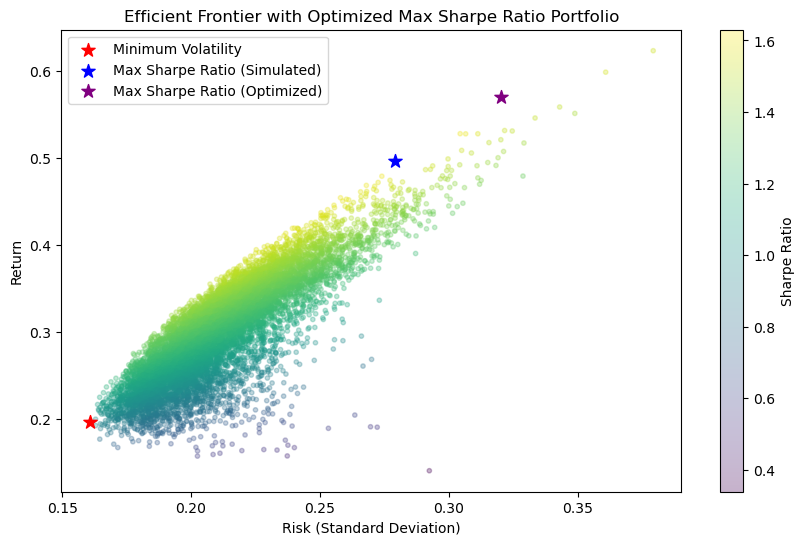

Max Sharpe Portfolio Weights (Optimized): [0.00000000e+00 0.00000000e+00 6.05436419e-01 0.00000000e+00
 3.94563581e-01 1.63660206e-17]
Min Volatility Portfolio Weights: [0.1048091  0.15683395 0.01678496 0.4365969  0.1648773  0.12009778]
Portfolio Simulation 5-95 Percentiles: [ 69978.09355914  94983.07930682 117199.77795646 144048.79176469
 197913.89236627]


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Carica i dati storici
file_path = r'C:\Users\Mattia\Desktop\Returns.xlsx'  # Aggiorna con il percorso del file
data_foglio1 = pd.read_excel(file_path, sheet_name='Foglio1', engine='openpyxl')

# Imposta l'indice come 'Date' e converti i dati in valori numerici
data_foglio1.set_index('Date', inplace=True)
returns_data = data_foglio1.apply(pd.to_numeric, errors='coerce')
returns_data = returns_data.replace([np.inf, -np.inf], np.nan).dropna().astype(float)

# Calcolo dei rendimenti geometrici annualizzati e della matrice di covarianza
geometric_mean_daily = (1 + returns_data).prod() ** (1 / len(returns_data)) - 1
annual_geometric_mean = (1 + geometric_mean_daily) ** 252 - 1
cov_matrix = returns_data.cov() * 252

# Definisci il tasso privo di rischio
risk_free_rate = 0.042

# Funzione per calcolare il rapporto di Sharpe negativo
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_stddev
    return -sharpe_ratio  # Negativo per minimizzare

# Vincoli: la somma dei pesi deve essere 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Limiti dei pesi (ad esempio, tra 0 e 1 per non includere vendite allo scoperto)
bounds = tuple((0, 1) for _ in range(len(annual_geometric_mean)))

# Pesi iniziali casuali
initial_weights = np.array([1 / len(annual_geometric_mean)] * len(annual_geometric_mean))

# Ottimizzazione per massimizzare il rapporto di Sharpe
optimized_result = minimize(neg_sharpe_ratio, initial_weights, args=(annual_geometric_mean, cov_matrix, risk_free_rate),
                            method='SLSQP', bounds=bounds, constraints=constraints)

# Estrai i pesi ottimali e calcola il rapporto di Sharpe
optimal_weights = optimized_result.x
optimal_return = np.dot(optimal_weights, annual_geometric_mean)
optimal_stddev = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
optimal_sharpe_ratio = (optimal_return - risk_free_rate) / optimal_stddev

print("Optimal Weights for Maximum Sharpe Ratio:", optimal_weights)
print("Optimal Sharpe Ratio:", optimal_sharpe_ratio)

# Efficient frontier simulation
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

np.random.seed(42)
for i in range(num_portfolios):
    weights = np.random.random(len(annual_geometric_mean))
    weights /= np.sum(weights)  # Normalizza i pesi
    weights_record.append(weights)
    portfolio_return = np.dot(weights, annual_geometric_mean)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    results[0, i] = portfolio_stddev
    results[1, i] = portfolio_return
    results[2, i] = (portfolio_return - risk_free_rate) / portfolio_stddev  # Sharpe ratio

# Identifica i portafogli ottimali nella simulazione
max_sharpe_idx = np.argmax(results[2])
min_vol_idx = np.argmin(results[0])
max_sharpe_weights = weights_record[max_sharpe_idx]
min_vol_weights = weights_record[min_vol_idx]

# Grafico della frontiera efficiente con il portafoglio ottimizzato
plt.figure(figsize=(10, 6))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(results[0, min_vol_idx], results[1, min_vol_idx], color='red', marker='*', s=100, label='Minimum Volatility')
plt.scatter(results[0, max_sharpe_idx], results[1, max_sharpe_idx], color='blue', marker='*', s=100, label='Max Sharpe Ratio (Simulated)')
plt.scatter(optimal_stddev, optimal_return, color='purple', marker='*', s=100, label='Max Sharpe Ratio (Optimized)')
plt.title('Efficient Frontier with Optimized Max Sharpe Ratio Portfolio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.legend()
plt.show()

# Monte Carlo Simulation for 12-month projection
initial_investment = 70000
num_simulations = 10000
time_horizon = 252  # Simulate over 1 year of trading days
portfolio_simulation = []
for _ in range(num_simulations):
    simulated_returns = np.random.normal(
        np.dot(optimal_weights, annual_geometric_mean) / time_horizon,
        np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)) / time_horizon),
        time_horizon
    )
    portfolio_values = initial_investment * np.cumprod(1 + simulated_returns)
    portfolio_simulation.append(portfolio_values[-1])

# Analisi del rischio - Percentili dei risultati della simulazione
percentiles = np.percentile(portfolio_simulation, [5, 25, 50, 75, 95])
print("Max Sharpe Portfolio Weights (Optimized):", optimal_weights)
print("Min Volatility Portfolio Weights:", min_vol_weights)
print("Portfolio Simulation 5-95 Percentiles:", percentiles)


In [19]:
# Identifica i portafogli ottimali nella simulazione casuale
max_sharpe_idx = np.argmax(results[2])
min_vol_idx = np.argmin(results[0])
max_sharpe_weights_simulated = weights_record[max_sharpe_idx]
min_vol_weights = weights_record[min_vol_idx]

# Calcola rendimento, rischio e rapporto di Sharpe per il portafoglio con massimo Sharpe simulato
max_sharpe_return_simulated = results[1, max_sharpe_idx]
max_sharpe_risk_simulated = results[0, max_sharpe_idx]
max_sharpe_ratio_simulated = results[2, max_sharpe_idx]

# Stampa dei risultati per il portafoglio con massimo Sharpe ottenuto tramite simulazione
print("Max Sharpe Ratio Portfolio (Simulated):")
print(f"  Expected Return: {max_sharpe_return_simulated:.4f}")
print(f"  Risk (Standard Deviation): {max_sharpe_risk_simulated:.4f}")
print(f"  Sharpe Ratio: {max_sharpe_ratio_simulated:.4f}")

# Calcola rendimento, rischio e rapporto di Sharpe per il portafoglio con massimo Sharpe ottimizzato
optimal_return = np.dot(optimal_weights, annual_geometric_mean)
optimal_stddev = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
optimal_sharpe_ratio = (optimal_return - risk_free_rate) / optimal_stddev

# Stampa dei risultati per il portafoglio con massimo Sharpe ottenuto tramite ottimizzazione
print("\nMax Sharpe Ratio Portfolio (Optimized):")
print(f"  Optimal Weights: {optimal_weights}")
print(f"  Expected Return: {optimal_return:.4f}")
print(f"  Risk (Standard Deviation): {optimal_stddev:.4f}")
print(f"  Sharpe Ratio: {optimal_sharpe_ratio:.4f}")


Max Sharpe Ratio Portfolio (Simulated):
  Expected Return: 0.4966
  Risk (Standard Deviation): 0.2789
  Sharpe Ratio: 1.6301

Max Sharpe Ratio Portfolio (Optimized):
  Optimal Weights: [0.00000000e+00 0.00000000e+00 6.05436419e-01 0.00000000e+00
 3.94563581e-01 1.63660206e-17]
  Expected Return: 0.5701
  Risk (Standard Deviation): 0.3200
  Sharpe Ratio: 1.6502


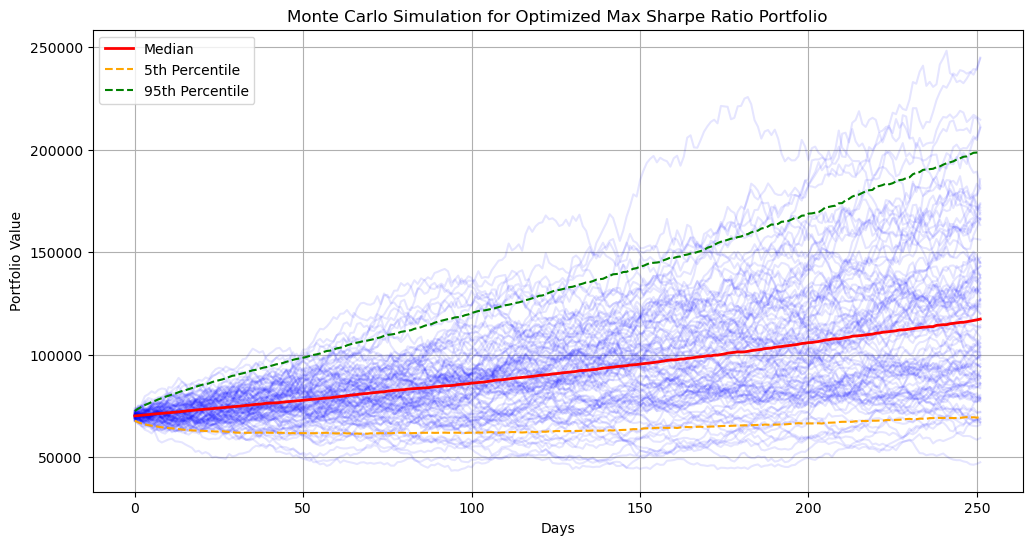

In [20]:
# Monte Carlo Simulation per il portafoglio ottimizzato
plt.figure(figsize=(12, 6))

# Simulazione
for i in range(100):
    simulated_returns_optimized = np.random.normal(
        np.dot(optimal_weights, annual_geometric_mean) / time_horizon,
        np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)) / time_horizon),
        time_horizon
    )
    portfolio_values_optimized = initial_investment * np.cumprod(1 + simulated_returns_optimized)
    plt.plot(portfolio_values_optimized, color='blue', alpha=0.1)

# Calcolo mediana e percentile per ogni giorno della simulazione
simulation_array_optimized = np.array([initial_investment * np.cumprod(1 + np.random.normal(
    np.dot(optimal_weights, annual_geometric_mean) / time_horizon,
    np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)) / time_horizon),
    time_horizon)) for _ in range(num_simulations)])

median_optimized = np.median(simulation_array_optimized, axis=0)
percentiles_5_optimized = np.percentile(simulation_array_optimized, 5, axis=0)
percentiles_95_optimized = np.percentile(simulation_array_optimized, 95, axis=0)

# Mediana e percentili
plt.plot(median_optimized, color='red', label='Median', linewidth=2)
plt.plot(percentiles_5_optimized, color='orange', linestyle='--', label='5th Percentile', linewidth=1.5)
plt.plot(percentiles_95_optimized, color='green', linestyle='--', label='95th Percentile', linewidth=1.5)

plt.title("Monte Carlo Simulation for Optimized Max Sharpe Ratio Portfolio")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()

